# Cluster Validation

## Import libraries for analysis

In [2]:
# Built-in libraries
import time
from itertools import product
from math import log

# NumPy, SciPy and Pandas
import numpy as np
import pandas as pd

# Scikit-Learn
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
combined_profiles = pd.read_csv('final_profiles.csv')

/Users/yangxiya/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Separate residential and non-residential buildings
is_residential = combined_profiles.Industry == 'Residential'
residential_profiles = combined_profiles.loc[is_residential, :]
non_residential_profiles = combined_profiles.loc[~is_residential, :]

# reset index
residential_profiles.reset_index(inplace = True, drop = True)
non_residential_profiles.reset_index(inplace = True, drop = True)

## Cluster validation functions

In [61]:
def divide(data, labels):
    clusters = set(labels)
    clusters_data = []
    for cluster in clusters:
        clusters_data.append(data[labels == cluster, :])
    return clusters_data

def get_centroids(clusters):
    centroids = []
    for cluster_data in clusters:
        centroids.append(cluster_data.mean(axis=0))
    return centroids

In [68]:
attribute_num = 24

def cohesion(data, labels):
    clusters = sorted(set(labels))
    sse = 0
    for cluster in clusters:
        cluster_data = data[labels == cluster, :]
        centroid = cluster_data.mean(axis = 0)
        sse += ((cluster_data - centroid)**2).sum()
    return sse

def separation(data, labels, cohesion_score):
    # calculate separation as SST - SSE
    return cohesion(data, np.zeros(data.shape[0])) - cohesion_score

def SST(data):
    c = get_centroids([data])
    return ((data - c) ** 2).sum()

def SSE(clusters, centroids):
    result = 0
    for cluster, centroid in zip(clusters, centroids):
        result += ((cluster - centroid) ** 2).sum()
    return result

# Clear the store before running each time
within_cluster_dist_sum_store = {}
def within_cluster_dist_sum(cluster, centroid, cluster_id):
    if cluster_id in within_cluster_dist_sum_store:
        return within_cluster_dist_sum_store[cluster_id]
    else:
        result = (((cluster - centroid) ** 2).sum(axis=1)**.5).sum()
        within_cluster_dist_sum_store[cluster_id] = result
    return result

def RMSSTD(data, clusters, centroids):
    df = data.shape[0] - len(clusters)
    return (SSE(clusters, centroids) / (attribute_num * df)) ** .5

# equal to separation / (cohesion + separation)
def RS(data, clusters, centroids):
    sst = SST(data)
    sse = SSE(clusters, centroids)
    return (sst - sse) / sst

def DB_find_max_j(clusters, centroids, i):
    max_val = 0
    max_j = 0
    for j in range(len(clusters)):
        if j == i:
            continue
        cluster_i_stat = within_cluster_dist_sum(clusters[i], centroids[i], i) / clusters[i].shape[0]
        cluster_j_stat = within_cluster_dist_sum(clusters[j], centroids[j], j) / clusters[j].shape[0]
        val = (cluster_i_stat + cluster_j_stat) / (((centroids[i] - centroids[j]) ** 2).sum() ** .5)
        if val > max_val:
            max_val = val
            max_j = j
    return max_val

def DB(data, clusters, centroids):
    result = 0
    for i in range(len(clusters)):
        result += DB_find_max_j(clusters, centroids, i)
    return result / len(clusters)

def XB(data, clusters, centroids):
    sse = SSE(clusters, centroids)
    min_dist = ((centroids[0] - centroids[1]) ** 2).sum()
    for centroid_i, centroid_j in list(product(centroids, centroids)):
        if (centroid_i - centroid_j).sum() == 0:
            continue
        dist = ((centroid_i - centroid_j) ** 2).sum()
        if dist < min_dist:
            min_dist = dist
    return sse / (data.shape[0] * min_dist)

In [69]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabaz_score

within_cluster_dist_sum_store = {}

def get_validation_scores(data, labels):
    clusters = divide(data, labels)
    centroids = get_centroids(clusters)
    
    scores = {}

    scores['cohesion'] = cohesion(data, labels)
    scores['separation'] = separation(data, labels, scores['cohesion'])
    scores['calinski_harabaz_score'] = calinski_harabaz_score(data, labels)
    scores['RMSSTD'] = RMSSTD(data, clusters, centroids)
    scores['RS'] = RS(data, clusters, centroids)
    scores['DB'] = DB(data, clusters, centroids)
    scores['XB'] = XB(data, clusters, centroids)
    
    return scores

In [6]:
# get the labels for the corresponding subplot
def get_labels(plot_order, labels_dir):
    algo_list = ['kmeans', 'bisectingkmeans', 'gmm']
    current_row = (plot_order-1) // len(algo_list) + 1
    current_col = (plot_order-1) % len(algo_list)
    current_algo = algo_list[current_col]
    current_k = current_row + 1
    return np.load('./%s/%s/params[k=%d].npy' % (labels_dir, current_algo, current_k))

In [1]:
def plot_validation_scores(scores):
    plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='k')

    for idx in range(7):
        score_name = ['cohesion', 'separation', 'calinski_harabaz_score', 'DB', 'RS', 'RMSSTD', 'XB'][idx]
        ax = plt.subplot(3,3,idx+1)

        for i in range(3):
            algo_name = ['K-Means', 'Bisecting K-Means', 'Gaussian Mixture Model'][i]
            values = []
            for j in range(9):
                plot_order = j * 3 + i
                values.append(scores[plot_order][score_name])
            plt.plot(values, label=algo_name)
        plt.title(score_name)
        plt.xticks(range(9), range(2,11))
        plt.xlabel('k')

    plt.show()
    plt.close()

In [5]:
settings_list = [
    {
        'profiles': combined_profiles,
        'labels_dir': 'final_labels'
    },
    {
        'profiles': residential_profiles,
        'labels_dir': 'residential_labels',
    },
    {
        'profiles': non_residential_profiles,
        'labels_dir': 'non_residential_labels',
    },
]

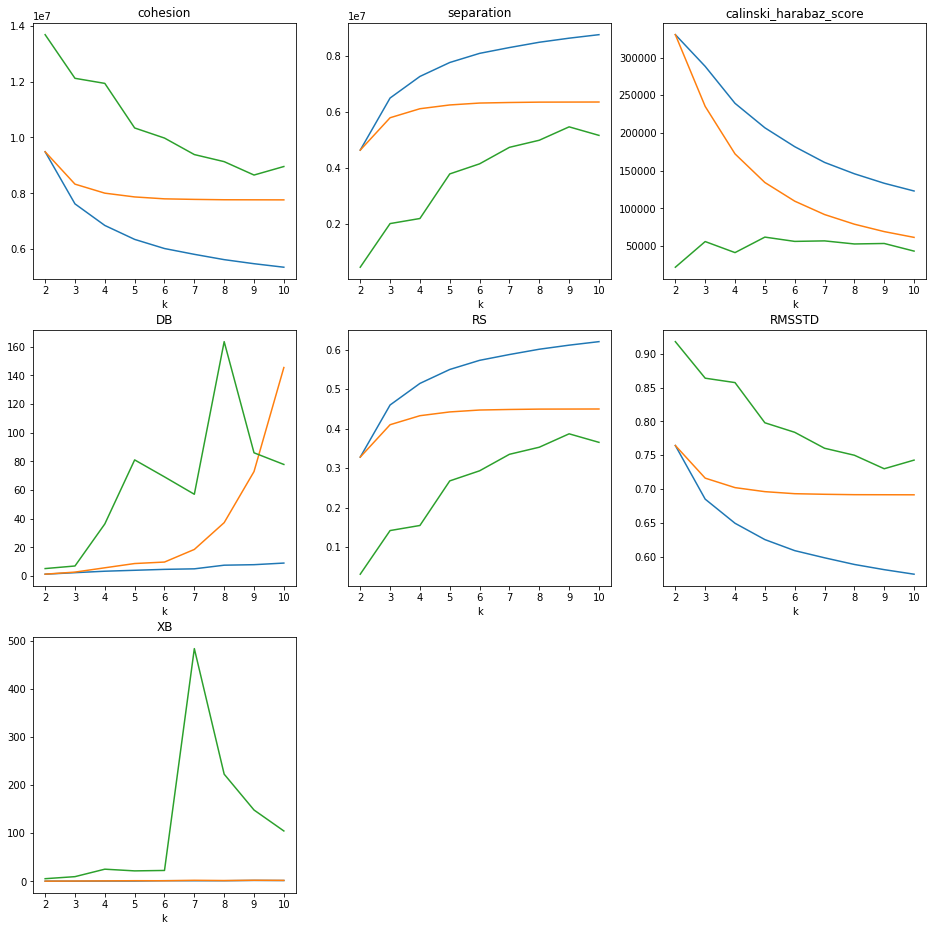

In [80]:
for settings in settings_list:

    data = settings['profiles'].iloc[:, 3:3+24].as_matrix()
    scores = []

    start = time.time()
    for i in range(1, 3*9+1):
        labels = get_labels(i, settings['labels_dir'])
        scores.append(get_validation_scores(data, labels))
    print('Time taken for computing scores: %.2f' % (time.time() - start))
    
    plot_validation_scores(scores)